# CNN

VAE를 통해 차원을 축소한 데이터 사용

In [4]:
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, initializers
from keras.optimizers import RMSprop, Adadelta, Adam, SGD, Adagrad
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import pickle # 파이썬 객체저장을 위한 모듈

## 사전값 셋팅 확인 필수

In [39]:
df = 'main'   # 수정필수
# core/all/main




# core설정시 확인해야 함
# R을 통해 확인한 stepwise 유의 변수 리스트
core_factors = ['DR00000136','6000201001O0','6000903016D1','FNMKFN02','6000901002D1','S41000210FD1',
'6000207003O0','DR00000052','6000906001D6','DR00000156','6000901001D3','DR00000082',
'S41000210FD2','6000902001D2','6000908001D3','6000904001D3','6000908001D2','S41B0D1009O0',
'6000901002D3','6000903001D2','6000403001O0','CO10100170O0','DR00000113','6000908001D7']

#  키별로 비율 배분이 잘 됐는지 확인
if df == 'all':
    max_idx = 707
else:
    max_idx = 124
    

In [40]:
if df == 'all':
    file_nm = "./pickles/vae_all.p"
elif df == 'main':
    file_nm = "./pickles/vae_main.p"
elif df == 'core':
    file_nm = "./pickles/vae_core.p"

#파이썬 객체 읽어오기
with open(file_nm, 'rb') as file:  
    z_train = pickle.load(file)
    z_test = pickle.load(file)
    x_train = pickle.load(file)   # 0~1 스케일된 데이터 유의!
    x_test = pickle.load(file)    # 0~1 스케일된 데이터 유의!
    y_train = pickle.load(file)
    y_test = pickle.load(file)
    train_set = pickle.load(file)
    test_set = pickle.load(file)   
    

In [41]:
df, z_train.shape, z_test.shape, y_train.shape, y_test.shape

('main', (755, 32), (333, 32), (755,), (333,))

### 모델 입력값 설정

In [42]:
np.random.seed(42)

# 분류갯수
classes = 2

# 학습데이터
img_rows = 1
img_cols = z_train.shape[1] 



In [43]:
img_rows, img_cols

(1, 32)

### input shape 변경

In [44]:
# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
# X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = z_train.reshape(z_train.shape[0], 1, z_train.shape[1], 1) # (1, # of features, # of chnnels) # input.shape[1:끝]
X_test = z_test.reshape(z_test.shape[0], 1, z_test.shape[1], 1) # (1, # of features, # of chnnels) # input.shape[1:끝]

# 변수명 전환
Y_train = y_train
Y_test = y_test

input_shape= X_train.shape[1:4]
print(input_shape)

(1, 32, 1)


In [45]:
z_train.shape[1]

32

In [46]:

# if x_train.shape[1] >= 100:
#     filter_size = 8
# elif x_train.shape[1] >= 50:
#     filter_size = 8
# else:
#     filter_size = 8

filter_size = 4
batch_size = 50
epochs = 50

print("한번에 처리될 row 수 :", batch_size, ",   한 row date가 반복 학습될 횟수 : ", epochs, ",   ", x_train.shape[0]*epochs, "개 row에 대해 학습하게 됨")

print("\n< 처리기준 >")
print_string = "n : {}, m :{}, filter_size : {}, batch_size : {}, epochs : {}"
print(print_string.format(x_train.shape[0],x_train.shape[1],filter_size,batch_size,epochs))


한번에 처리될 row 수 : 50 ,   한 row date가 반복 학습될 횟수 :  50 ,    37750 개 row에 대해 학습하게 됨

< 처리기준 >
n : 755, m :1, filter_size : 4, batch_size : 50, epochs : 50


In [47]:
# Y값을 1개항목에서 카테고리화 함
Y_train = to_categorical(y_train, num_classes=classes) # one-hot 인코딩
Y_test = to_categorical(y_test, num_classes=classes) # one-hot 인코딩

Y_train.shape, Y_test.shape

((755, 2), (333, 2))

## CNN 모델 설계

In [48]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((755, 1, 32, 1), (333, 1, 32, 1), (755, 2), (333, 2))

In [49]:
# filter_size = 4


In [50]:
# 1. 모델구성
model = Sequential()

model.add(Conv2D(filter_size, (1, 2), input_shape = X_train.shape[1:4], activation = 'relu', padding='same', init="he_normal")) # 2D (1, 4) size 필터
model.add(Activation('elu'))

model.add(Conv2D(filter_size*2, (1, 4), padding='same', kernel_initializer="he_normal"))
# model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(MaxPooling2D((1, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(filter_size*2, (1, 4), padding='same', kernel_initializer="he_normal"))
# model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(filter_size, (1, 4), kernel_initializer="he_normal"))
model.add(Activation('elu'))
# model.add(MaxPooling2D((1, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(classes, activation = 'sigmoid', init="glorot_normal"))# 마지막 class 분류

# 2. 모델 학습과정 설정하기
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 2), input_shape=(1, 32, 1), activation="relu", padding="same", kernel_initializer="he_normal")`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 32, 4)          12        
_________________________________________________________________
activation_9 (Activation)    (None, 1, 32, 4)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 32, 8)          136       
_________________________________________________________________
activation_10 (Activation)   (None, 1, 32, 8)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 32, 8)          264       
_________________________________________________________________
activation_11 (Activation)   (None, 1, 32, 8)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 29, 4)          132       
__________

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="sigmoid", kernel_initializer="glorot_normal")`


In [51]:

# 3. 모델 학습시키기
hist = model.fit(X_train, Y_train, batch_size = batch_size, epochs = batch_size, verbose = 1, validation_split = .2)



Train on 604 samples, validate on 151 samples
Epoch 1/50
604/604 [==============================] - 1s 1ms/step - loss: 0.6847 - acc: 0.6738 - val_loss: 1.4870 - val_acc: 0.0000e+00
Epoch 2/50
604/604 [==============================] - 0s 167us/step - loss: 0.5730 - acc: 0.7500 - val_loss: 1.4083 - val_acc: 0.0000e+00
Epoch 3/50
604/604 [==============================] - 0s 177us/step - loss: 0.5199 - acc: 0.7517 - val_loss: 1.3032 - val_acc: 0.0000e+00
Epoch 4/50
604/604 [==============================] - 0s 213us/step - loss: 0.4778 - acc: 0.7533 - val_loss: 1.2242 - val_acc: 0.0265
Epoch 5/50
604/604 [==============================] - 0s 185us/step - loss: 0.4440 - acc: 0.7699 - val_loss: 1.1646 - val_acc: 0.1126
Epoch 6/50
604/604 [==============================] - 0s 188us/step - loss: 0.4214 - acc: 0.7914 - val_loss: 1.1399 - val_acc: 0.2384
Epoch 7/50
604/604 [==============================] - 0s 178us/step - loss: 0.3937 - acc: 0.8146 - val_loss: 1.0031 - val_acc: 0.4371
Epoch 

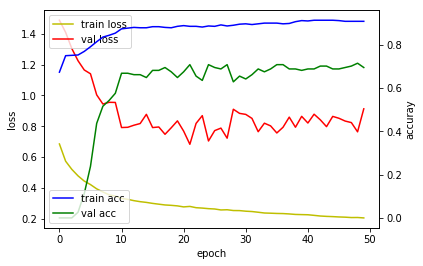

755/755 [==============================] - 0s 95us/step
Train score: 0.3442
Train accuracy: 0.8702
333/333 [==============================] - 0s 129us/step
Test score: 0.5640
Test accuracy: 0.7838


In [52]:

# 4. 학습과정 살펴보기(그래프)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


# 5. 모델 평가하기 - 테스트셋
'''
score는 비용함수에 대한 평가값
'''

score = model.evaluate(X_train, Y_train, verbose=1)
print('Train score: {:.4f}'.format(score[0]))
print('Train accuracy: {:.4f}'.format(score[1]))


score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

# model.evaluate ; 손실 값을 계산하는 데 사용
# model.predict_classes() ; 범주 출력을 계산하는 데 사용
# model.predict_proba() ; 범주 확률을 계산하는 데 사용


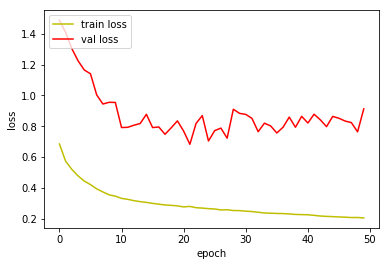

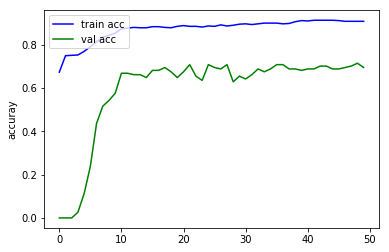

In [53]:

# 5. 분리된 그래프

# loss
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

# accuray
fig, acc_ax = plt.subplots()

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')

plt.show()
